**<center>===========================================================================================================</center>**
**<center>All Necessary Imports</center>**
**<center>===========================================================================================================</center>**

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

**<center>===========================================================================================================</center>**
**<center>Load the Data</center>**
**<center>===========================================================================================================</center>**

In [3]:
df_preprocessed = pd.read_csv('data/processed/preprocessed_data.csv')

with open('data/processed/feature_categories.json') as f:
    feature_categories = json.load(f)

continuous_features = feature_categories['continuous_features']
categorical_features = feature_categories['categorical_features']
target = feature_categories['target']

print(df_preprocessed.describe())

       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count     101766.000000       101766.000000   101766.000000    101766.000000   
mean           4.395987           43.095641        1.339730        16.021844   
std            2.985108           19.674362        1.705807         8.127566   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           31.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  number_diagnoses  
count      101766.000000     101766.000000     101766.000000     101766.000000  
mean            0.369357          0.197836          0.635566          7.422607  
std             1.267265          0.

**<center>===========================================================================================================</center>**
**<center>Convert to Binary Classification & Class Imbalance Check</center>**
**<center>===========================================================================================================</center>**

readmitted
NO     54864
YES    46902
Name: count, dtype: int64
Proportion of 'NO': 53.91%
Proportion of 'YES': 46.09%


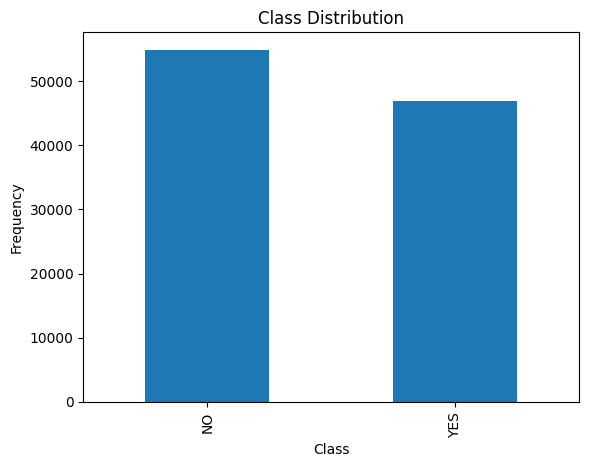

In [4]:
df_preprocessed['readmitted'] = df_preprocessed['readmitted'].apply(lambda x: 'YES' if x in ['>30', '<30'] else 'NO')
class_counts = df_preprocessed['readmitted'].value_counts()
total = class_counts.sum()
no_proportion = (class_counts['NO'] / total) * 100
yes_proportion = class_counts['YES'] / total * 100

print(class_counts)
print(f"Proportion of 'NO': {no_proportion:.2f}%")
print(f"Proportion of 'YES': {yes_proportion:.2f}%")

class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

**<center>===========================================================================================================</center>**
**<center>Continuous Features</center>**
**<center>===========================================================================================================</center>**

* __Advanced Visualizations__

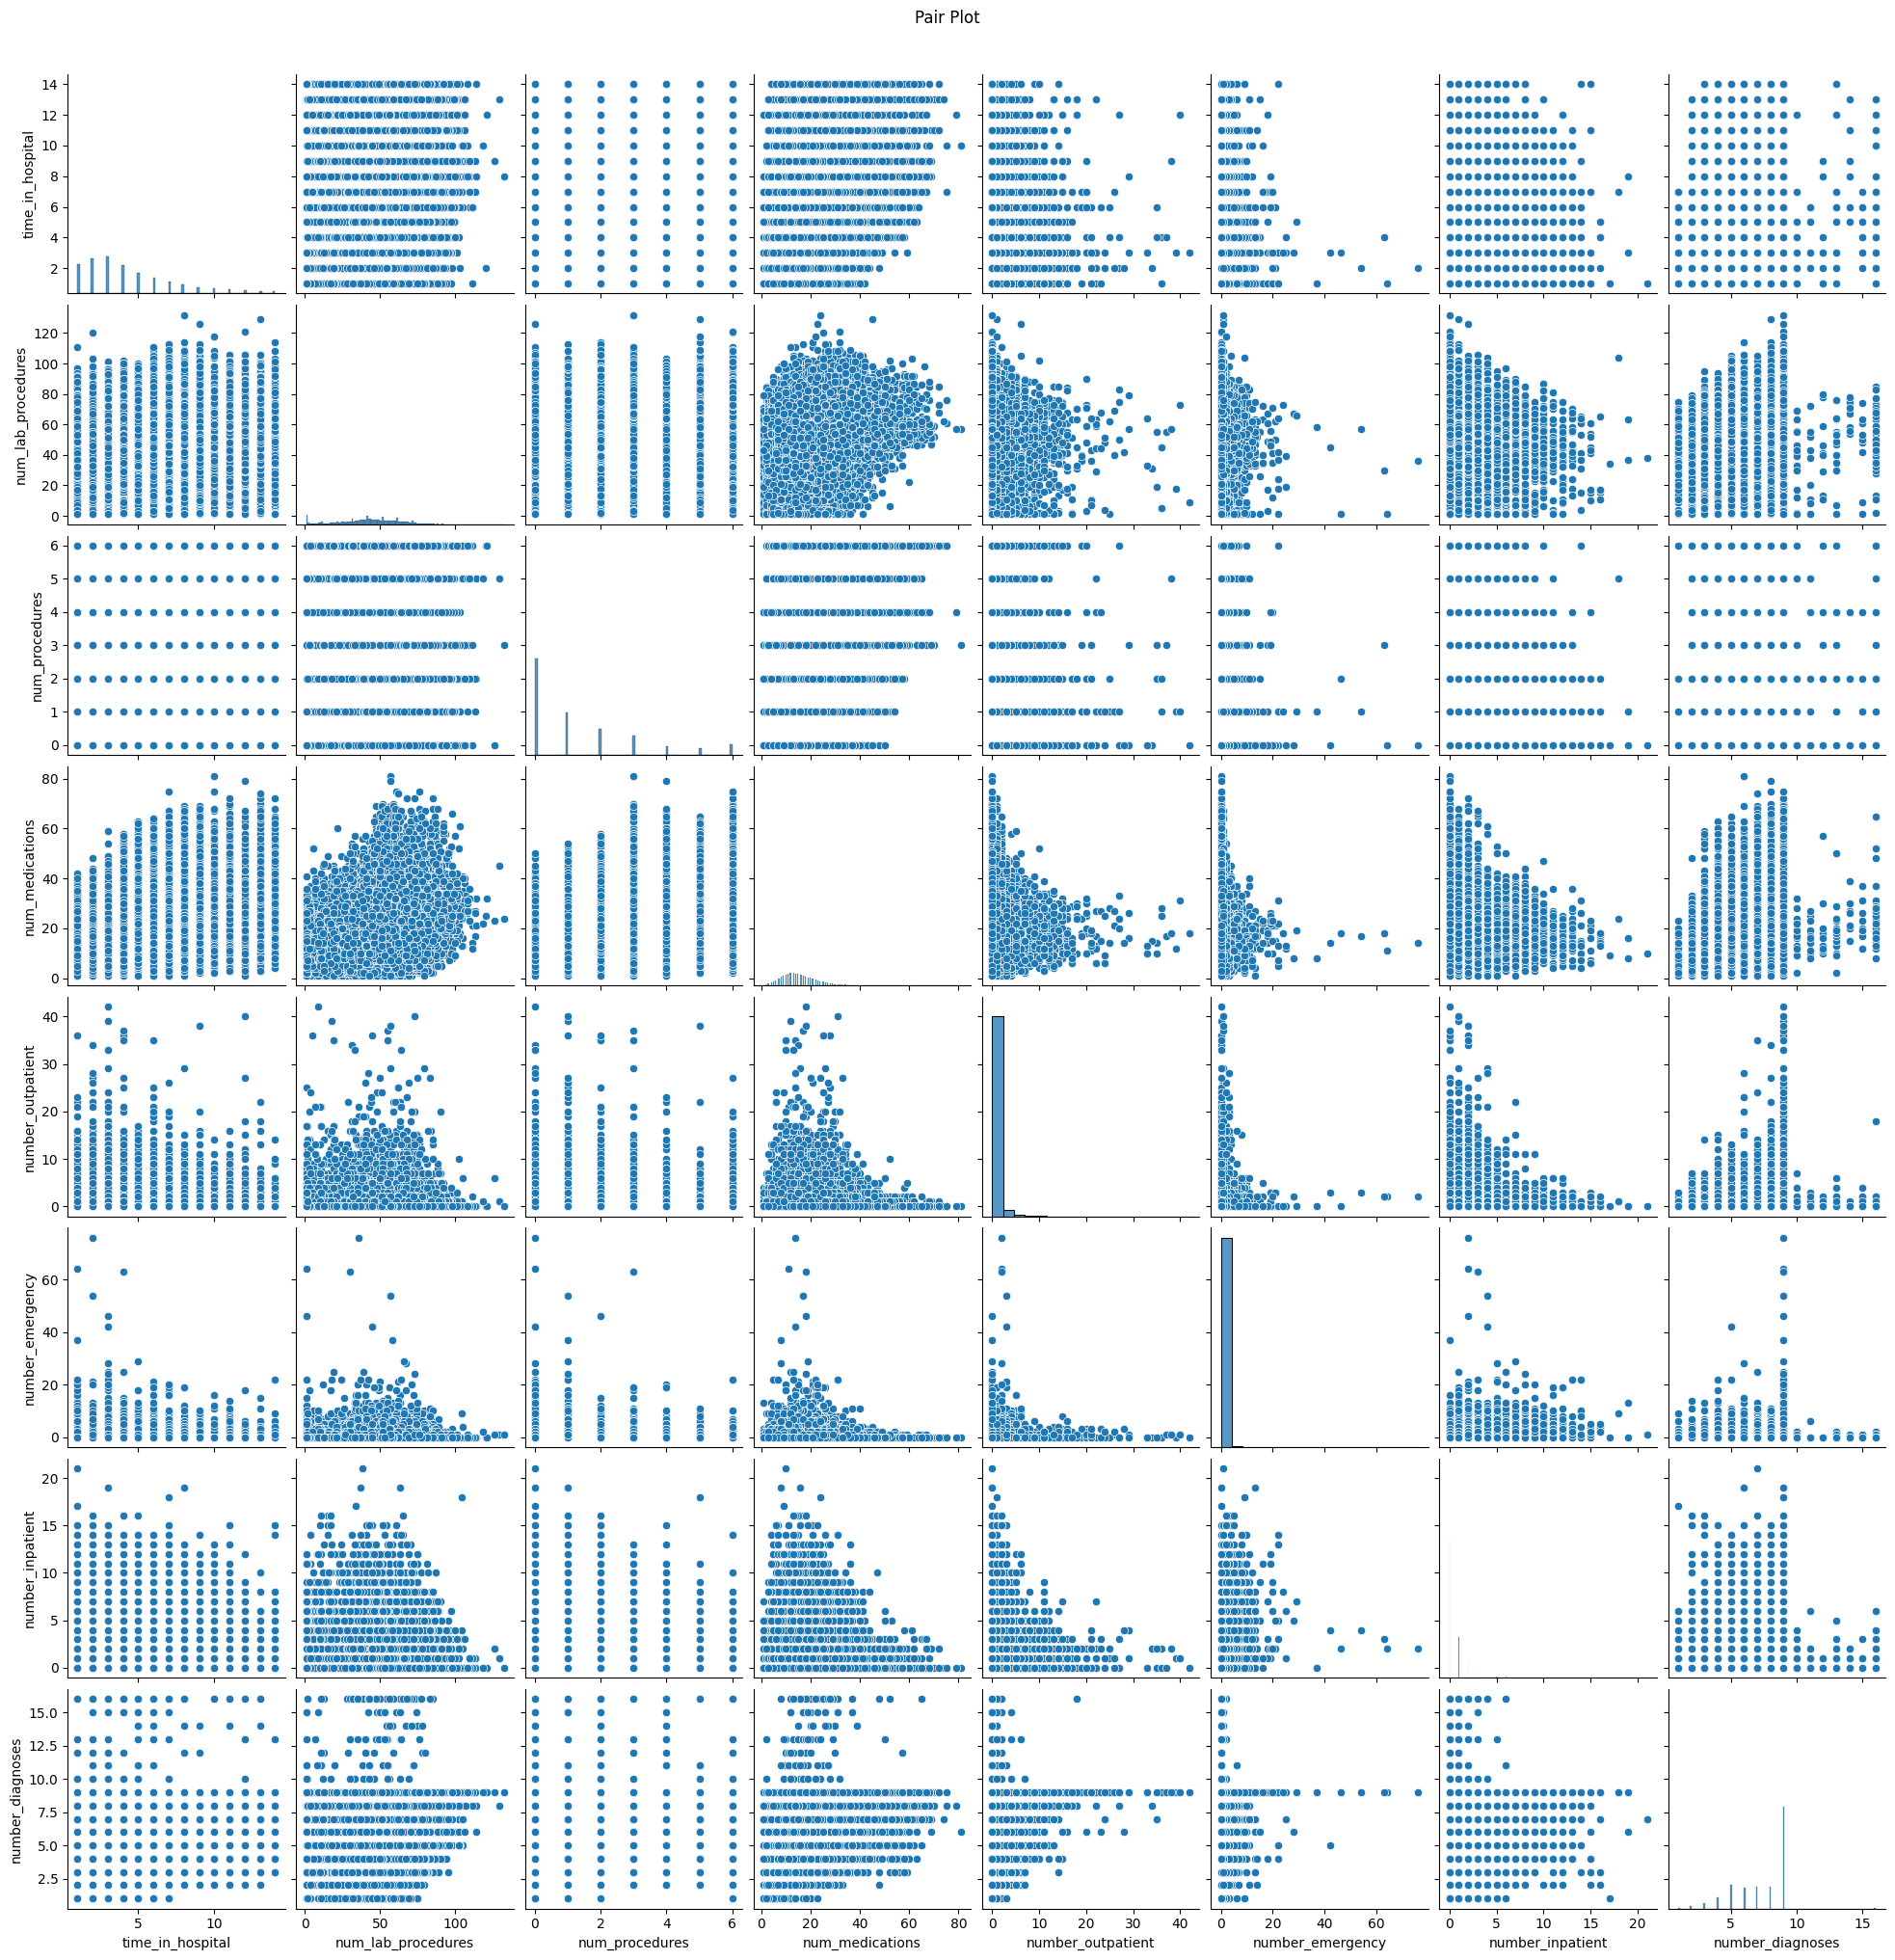

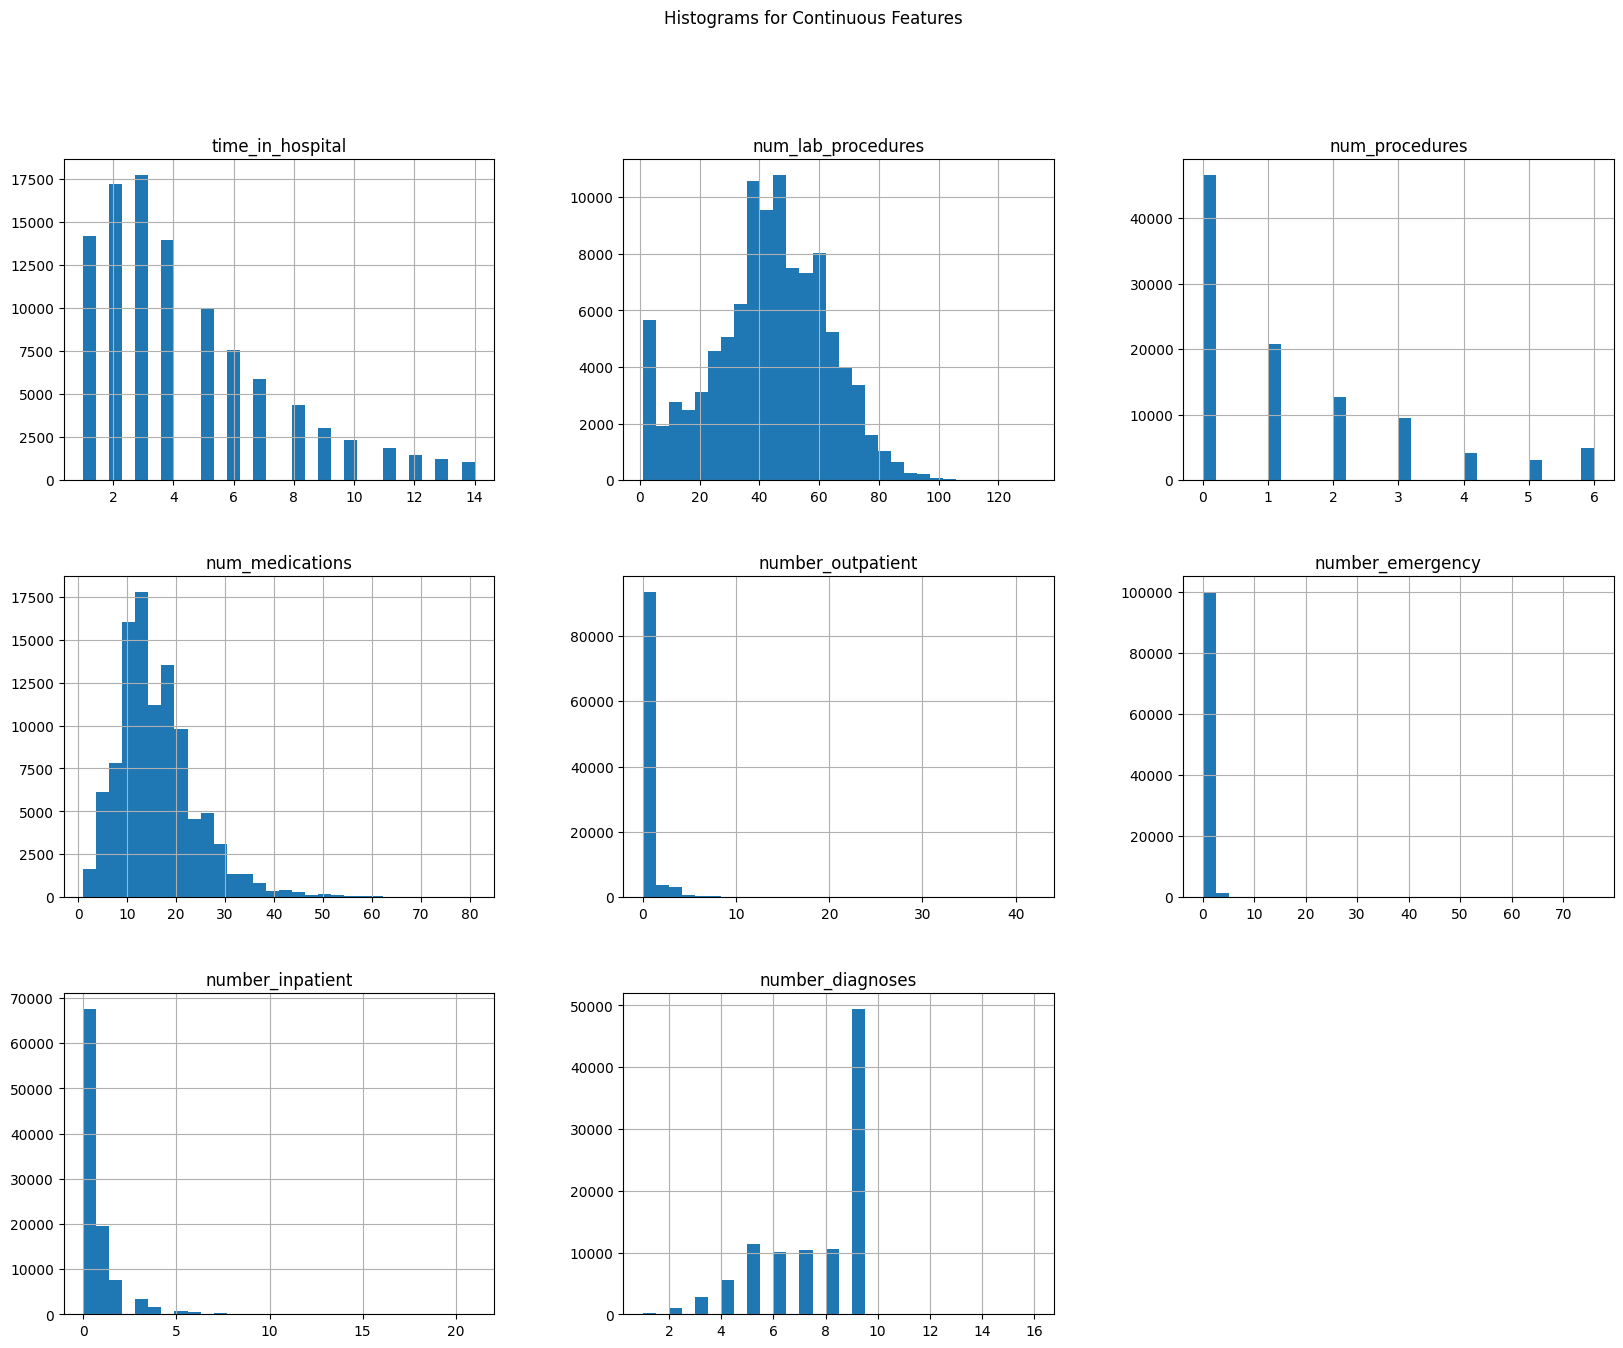

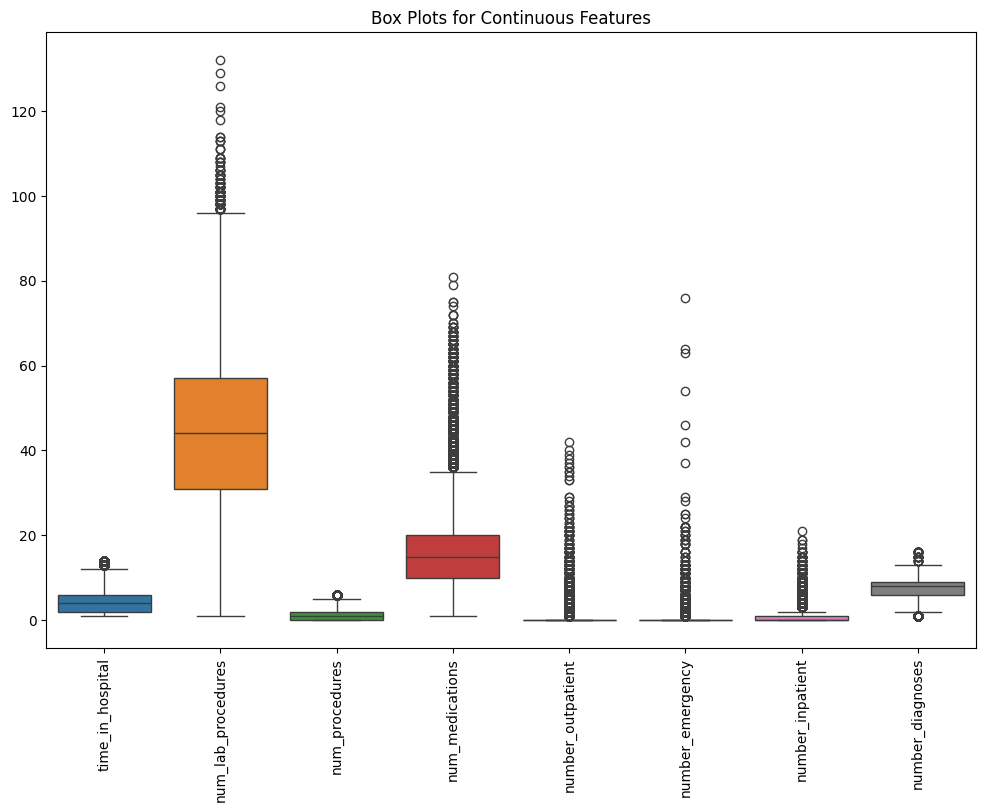

In [5]:
# Pair plot
sns.pairplot(df_preprocessed[continuous_features])
plt.suptitle("Pair Plot", y=1.02)
plt.show()

# Histograms
df_preprocessed[continuous_features].hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms for Continuous Features")
plt.show()

# Box plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_preprocessed[continuous_features])
plt.title("Box Plots for Continuous Features")
plt.xticks(rotation=90)
plt.show()

* __Outliers Removal__

In [6]:
def remove_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    num_outliers = outliers.shape[0]
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df, num_outliers

outliers_count = {}

for feature in continuous_features:
    df_preprocessed, num_outliers = remove_outliers_iqr(df_preprocessed, feature)
    outliers_count[feature] = num_outliers

df_cleaned = df_preprocessed
df_cleaned.reset_index(drop=True, inplace=True)

print("Number of outliers removed for each continuous feature:")

for feature, count in outliers_count.items():
    print(f"{feature}: {count} outliers removed")

print(f"\nSize of the updated dataset: {df_cleaned.shape}")

Number of outliers removed for each continuous feature:
time_in_hospital: 2252 outliers removed
num_lab_procedures: 118 outliers removed
num_procedures: 4644 outliers removed
num_medications: 2392 outliers removed
number_outpatient: 15395 outliers removed
number_emergency: 6934 outliers removed
number_inpatient: 3217 outliers removed
number_diagnoses: 222 outliers removed

Size of the updated dataset: (66592, 43)


* __Feature Engineering: Transformation of Skewed Features and Standardization__

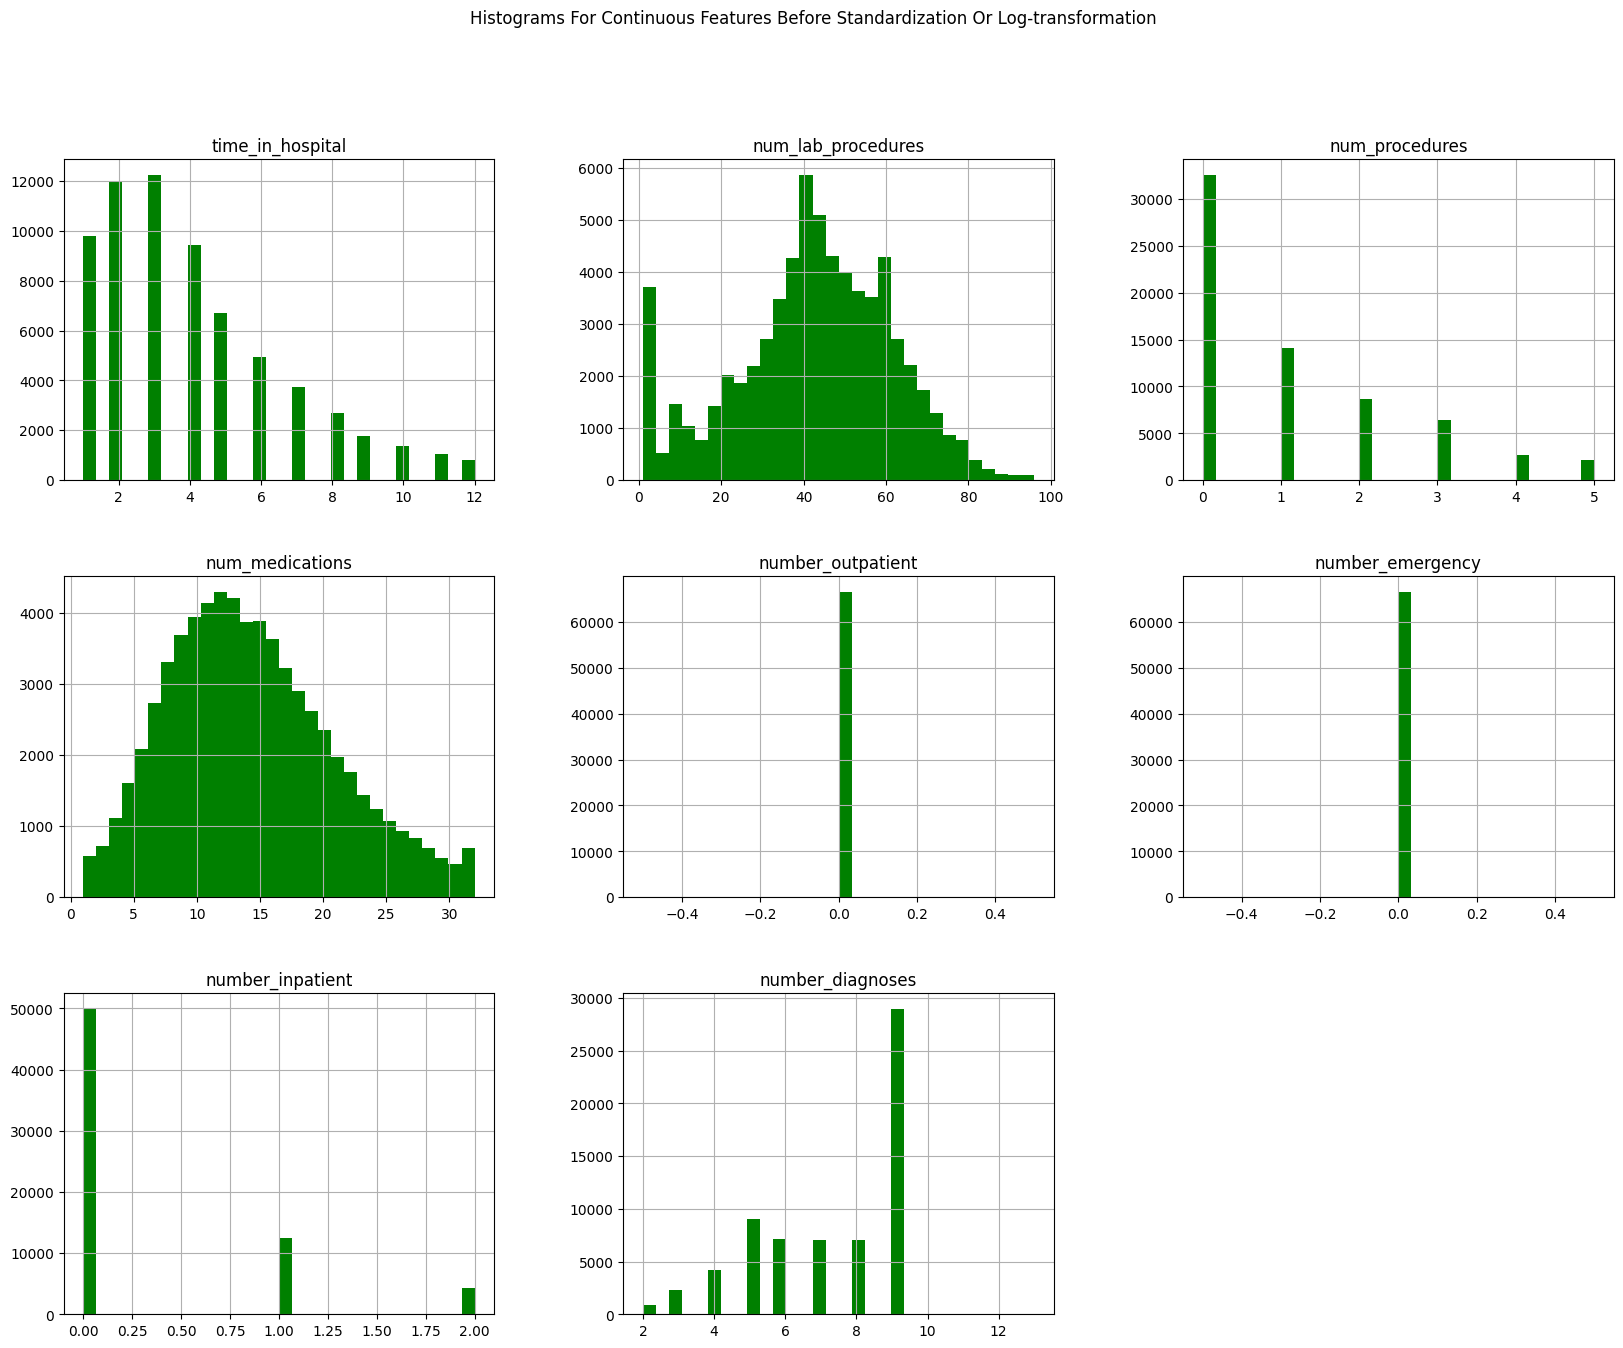

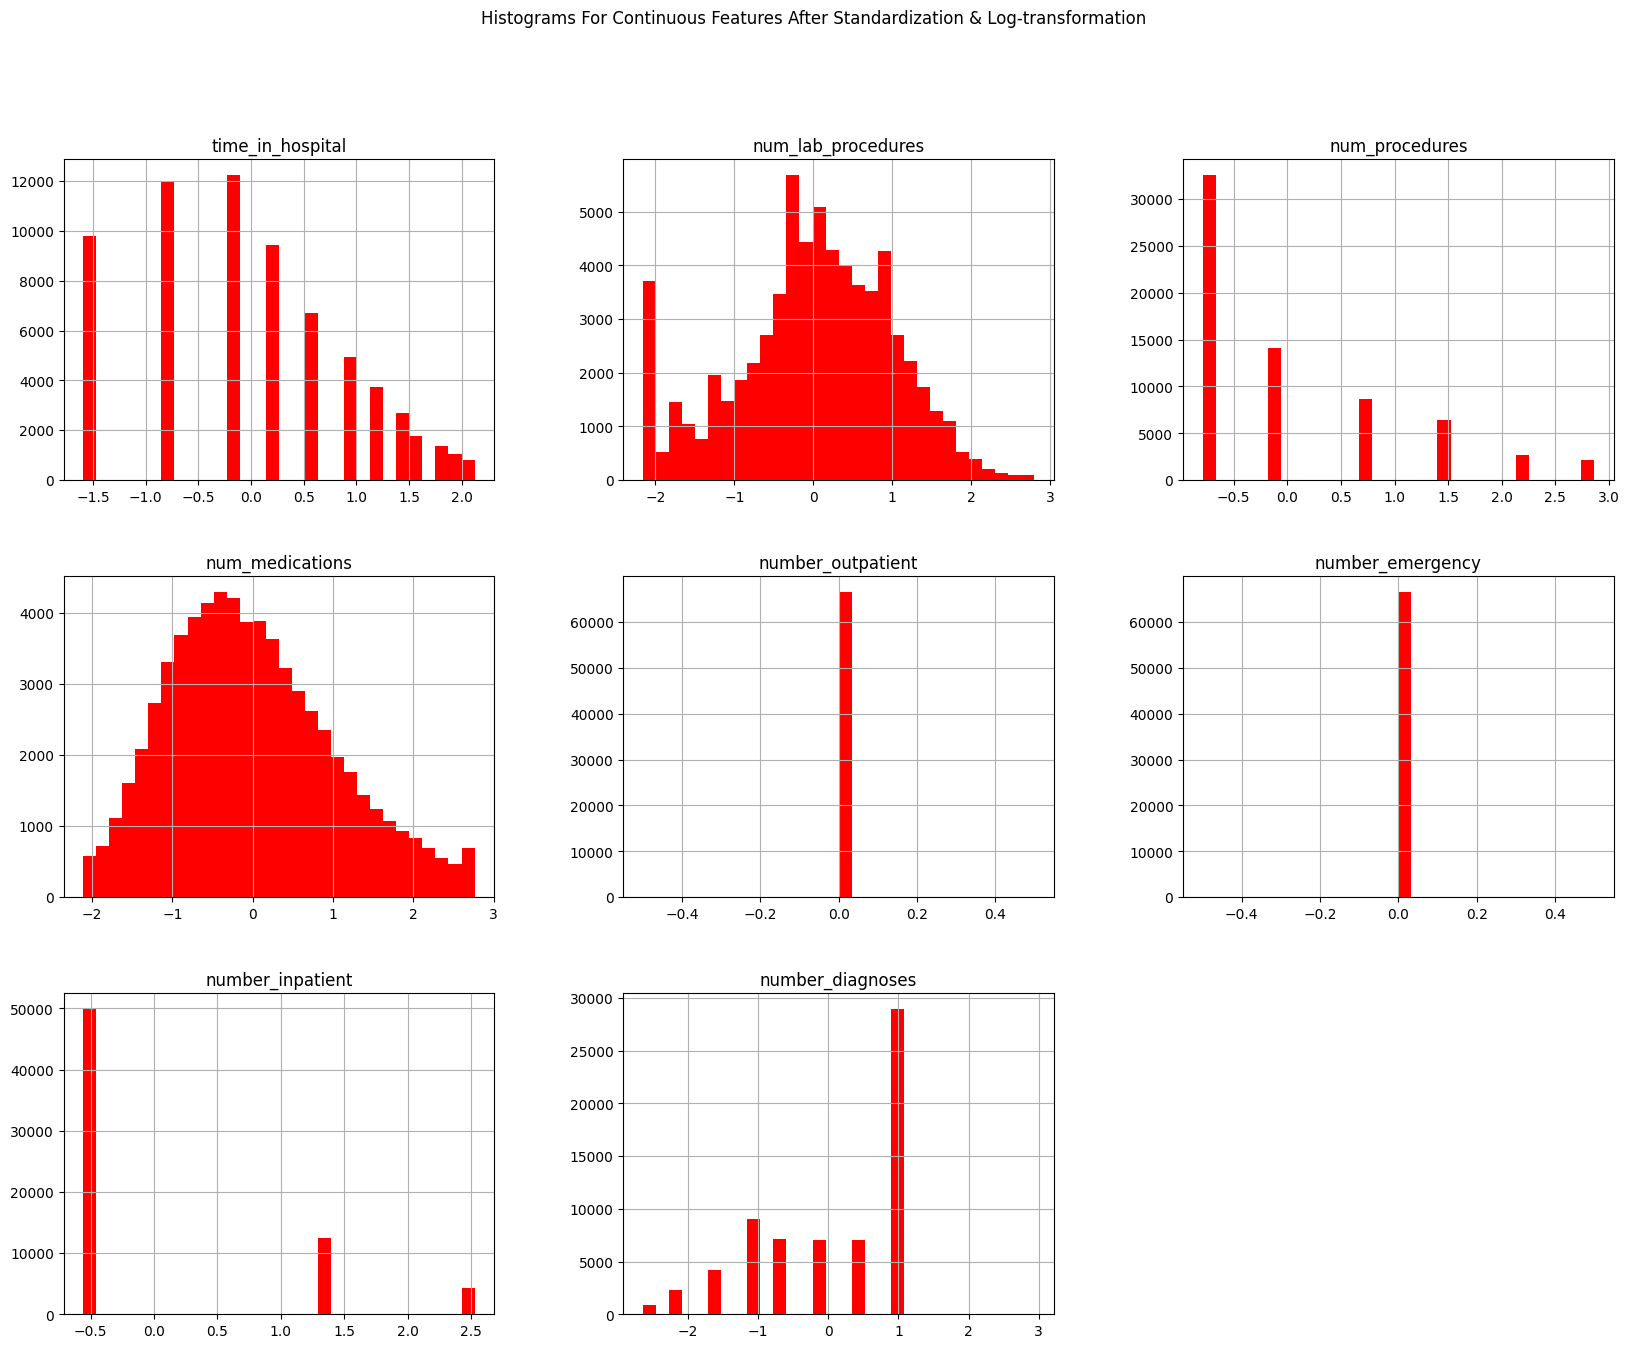

In [7]:
df_cleaned[continuous_features].hist(bins=30, figsize=(20, 15), color='green')
plt.suptitle("Histograms For Continuous Features Before Standardization Or Log-transformation")
plt.show()

# Log transformation for right skewed features
df_cleaned['time_in_hospital'] = np.log1p(df_cleaned['time_in_hospital'])
df_cleaned['number_inpatient'] = np.log1p(df_cleaned['number_inpatient'])

# Feature scaling
scaler = StandardScaler()
df_cleaned[continuous_features] = scaler.fit_transform(df_cleaned[continuous_features])

# Histograms after scaling
df_cleaned[continuous_features].hist(bins=30, figsize=(20, 15), color='red')
plt.suptitle("Histograms For Continuous Features After Standardization & Log-transformation")
plt.show()

**<center>===========================================================================================================</center>**
**<center>Categorical Features</center>**
**<center>===========================================================================================================</center>**

* __One-Hot Encoding__

In [8]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_array = one_hot_encoder.fit_transform(df_cleaned[categorical_features])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_array, columns=one_hot_encoder.get_feature_names_out(categorical_features))
df_one_hot_encoded = pd.concat([df_cleaned[continuous_features], 
                                one_hot_encoded_df], axis=1)

print(df_one_hot_encoded.shape)

(66592, 2290)


* __Remove Constant Features__

In [9]:
constant_features = [col for col in df_one_hot_encoded.columns if df_one_hot_encoded[col].nunique() == 1]
df_one_hot_encoded = df_one_hot_encoded.drop(columns=constant_features)

print(f"Number of constant features: {len(constant_features)}")
print(f"Constant features: {constant_features}")
print(df_one_hot_encoded.shape)

Number of constant features: 5
Constant features: ['number_outpatient', 'number_emergency', 'acetohexamide_No', 'examide_No', 'citoglipton_No']
(66592, 2285)


* __Correlation Matrix__

In [10]:
correlation_matrix = df_one_hot_encoded.corr()

threshold = 0.8
highly_correlated_pairs = []
features_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)
            features_to_drop.add(correlation_matrix.columns[i])

print(f"\n{len(highly_correlated_pairs)} highly correlated feature pairs identified (correlation coefficient > {threshold}):")

for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

print("\nFeatures to be dropped:")

for feature in features_to_drop:
    print(feature)

df_one_hot_encoded = df_one_hot_encoded.drop(columns=features_to_drop)

print("\nShape of the DataFrame after dropping highly correlated features:")
print(df_one_hot_encoded.shape)


30 highly correlated feature pairs identified (correlation coefficient > 0.8):
race_Caucasian and race_AfricanAmerican: -0.88
gender_Male and gender_Female: -1.00
admission_source_id_ Physician Referral and admission_source_id_ Emergency Room: -0.82
diag_2_376 and diag_1_375: 1.00
diag_2_99 and diag_1_98: 1.00
diag_3_943 and diag_2_942: 1.00
diag_3_E861 and diag_2_947: 1.00
diag_3_E892 and diag_2_869: 1.00
diag_3_E894 and diag_2_948: 1.00
metformin_Steady and metformin_No: -0.95
repaglinide_Steady and repaglinide_No: -0.95
nateglinide_Steady and nateglinide_No: -0.97
chlorpropamide_Steady and chlorpropamide_No: -0.96
glimepiride_Steady and glimepiride_No: -0.95
glipizide_Steady and glipizide_No: -0.94
glyburide_Steady and glyburide_No: -0.93
tolbutamide_Steady and tolbutamide_No: -1.00
pioglitazone_Steady and pioglitazone_No: -0.97
rosiglitazone_Steady and rosiglitazone_No: -0.98
acarbose_Steady and acarbose_No: -0.98
miglitol_Steady and miglitol_No: -0.98
troglitazone_Steady and trog

**<center>===========================================================================================================</center>**
**<center>Saving the One-Hot Encoded Data and Metadata</center>**
**<center>===========================================================================================================</center>**

In [11]:
updated_continuous_features = [col for col in continuous_features if col in df_one_hot_encoded.columns]
updated_categorical_features = [col for col in df_one_hot_encoded.columns if col not in updated_continuous_features]

feature_categories['continuous_features'] = updated_continuous_features
feature_categories['categorical_features'] = updated_categorical_features

with open('data/processed/feature_categories.json', 'w') as f:
    json.dump(feature_categories, f)

df_one_hot_encoded['readmitted'] = df_cleaned['readmitted']
df_one_hot_encoded.to_csv('data/processed/one_hot_encoded_data.csv', index=False)

print(f"No. of continuous features: {len(feature_categories['continuous_features'])}")
print(f"No. of categorical features: {len(feature_categories['categorical_features'])}")

No. of continuous features: 6
No. of categorical features: 2249
